# Veri Setinin İndirilmesi

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 96% 27.0M/28.0M [00:00<00:00, 150MB/s] 
100% 28.0M/28.0M [00:00<00:00, 140MB/s]


In [6]:
! unzip alzheimer-mri-dataset.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/Non_D

# Kütüphanelerin Yüklenmesi

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

from PIL import Image
from random import randint

from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG # Data augmentation için
from tensorflow.keras.preprocessing import image

from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model #Modeli çizmek için

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report # Confusion matrisi için
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.8.0


# Keşifsel Veri Analizi

In [3]:
levels =  ["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]
path = "Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'AD_result'])

data['path'] = path + '/' + data['image_file']
data['AD_result'] = data['AD_result'].map({'Non_Demented':'Non Demented', 'Very_Mild_Demented':'Very Mild Demented', 
                                           'Mild_Demented':'Mild Demented', 'Moderate_Demented':'Moderate Demented'})
samples = 6400

data.head()

,image_file,AD_result,path
0,Non_Demented/non_1684.jpg,Non Demented,Dataset/Non_Demented/non_1684.jpg
1,Non_Demented/non_204.jpg,Non Demented,Dataset/Non_Demented/non_204.jpg
2,Non_Demented/non_1055.jpg,Non Demented,Dataset/Non_Demented/non_1055.jpg
3,Non_Demented/non_1095.jpg,Non Demented,Dataset/Non_Demented/non_1095.jpg
4,Non_Demented/non_379.jpg,Non Demented,Dataset/Non_Demented/non_379.jpg


In [9]:
print('Tekrarlanan Örnek Sayısı: %d'%(data.duplicated().sum()))
print('Toplam Örnek Sayısı: %d'%(data.isnull().value_counts()))

Tekrarlanan Örnek Sayısı: 0
Toplam Örnek Sayısı: 6400


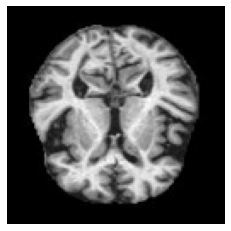

In [10]:
plt.figure()
image = cv2.imread("/content/Dataset/Very_Mild_Demented/verymild_1000.jpg")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [11]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (128, 128, 3)
Image Height: 128
Image Width: 128
Image Dimension: 3
Image Size: 48kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


İncelenen görüntü bir MR görüntüsüdür ancak 3 kanalı vardır, dolayısıyla bu görüntü RGB ölçeğindedir. Kısacası incelediğimiz görüntü bir X-Ray görüntüsü olsa bile RGB ölçeğindedir.

### Görüntülerin Dosyalara Kaydedilmesi

In [4]:
all_data = []

# Train-Test ayrımı için görüntüleri ve etiketlerini bir listede saklarız.
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (128, 128)) / 255.0
    if data['AD_result'][i] == "Non Demented":
      label = 0
    elif data['AD_result'][i] == "Very Mild Demented":
      label = 1
    elif data['AD_result'][i] == "Mild Demented":
      label = 2
    else:
      label = 3
    all_data.append([image, label])

In [5]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# NumPy array'e dönüştürürüz.
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4800, 128, 128, 3) (1600, 128, 128, 3) (4800,) (1600,)


In [6]:
a = np.zeros(4800, dtype = int)
b = np.zeros(1600, dtype = int)

In [7]:
train_labels = np.vstack((y_train, a)).T
test_labels =  np.vstack((y_test, b)).T

In [10]:
alzheimer_classes = dict({0:"Non_Demented",1:"Very_Mild_Demented",2:"Mild_Demented",3:"Moderate_Demented"})

# Verisetinden belirlenen sınıfları çıkarıp dosyalara kaydeden fonksiyon.
def save_images(x,y,classes,file_path):
    for i,j in classes.items():
        class_path = os.path.join(file_path, j)
        os.mkdir(class_path)
        photos = x[y[:,0] == i]
        for k,photo in enumerate(photos):
            num = str(k)
            plt.imsave(class_path + "/" + str(k)+".jpg",photo)   

In [11]:
# Verisetinde kullandığım sınıfları cifar100_classes isimli dosyaya kaydettim.
dataset_path = "Alzheimer"
os.mkdir(dataset_path)
train_dir = os.path.join(dataset_path, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(dataset_path, 'test')
os.mkdir(test_dir)

In [12]:
save_images(x_train,train_labels,alzheimer_classes,train_dir)
save_images(x_test,test_labels,alzheimer_classes,test_dir)

In [13]:
!zip -r /content/Alzheimer.zip /content/Alzheimer

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  adding: content/Alzheimer/test/Very_Mild_Demented/414.jpg (deflated 4%)
  adding: content/Alzheimer/test/Very_Mild_Demented/218.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/5.jpg (deflated 4%)
  adding: content/Alzheimer/test/Very_Mild_Demented/90.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/199.jpg (deflated 7%)
  adding: content/Alzheimer/test/Very_Mild_Demented/369.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/139.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/416.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/493.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/366.jpg (deflated 6%)
  adding: content/Alzheimer/test/Very_Mild_Demented/386.jpg (deflated 4%)
  adding: content/Alzheimer/test/Very_Mild_Demented/151.jpg (deflated 5%)
  adding: content/Alzheimer/test/Very_Mild_Demented/384.jpg (deflate

# Verilerin Hazırlanması

In [8]:
data_src="Dataset/"

In [9]:
data=[]
labels=[]

for d in os.listdir(data_src):
    for file in os.listdir(data_src+d):
        data.append(Image.open(data_src+d+'/'+file))
        labels.append(d)

In [10]:
# Convert each image into a numpy array
images=[]
for im in data:
    images.append(np.array(im))

#Convert the list of data into an array
images=np.array(images)

images.shape

(6400, 128, 128)

In [11]:
#Divide by 255 to standardize the values between 0 and 1
images=images/255

In [12]:
#Let's count how many of each category we have
non_demented = 0
mild_demented = 0
moderate_demented = 0
very_mild_demented = 0
for i in labels:
    if i=="Mild_Demented":
        mild_demented +=1
    elif i=="Moderate_Demented":
        moderate_demented +=1
    elif i=="Non_Demented":
        non_demented +=1
    else:
        very_mild_demented +=1
print("Non Demented: ", non_demented)
print("Very Mild: ",very_mild_demented)
print("Moderate: ",moderate_demented)
print("Mild :",mild_demented)

Non Demented:  3200
Very Mild:  2240
Moderate:  64
Mild : 896


In [13]:
#Now we change these values to numerical ones so that we can use to_categorical
#0 will be non, 1 will be very mild, 2 will be mild, 3 will be moderate
labels_num=[]

for i in labels:
    if i=="Mild_Demented":
        labels_num.append(2)
    elif i=="Moderate_Demented":
        labels_num.append(3)
    elif i=="Non_Demented":
        labels_num.append(0)
    else:
        labels_num.append(1)

#convert to a categorical target as expected by keras
labels=to_categorical(labels_num)  

labels.shape

(6400, 4)

In [14]:
#Reshape images to use in a neural network
images=images.reshape(6400,128,128,1)

In [15]:
#Split into a training set and test set
train_data, test_data, train_label, test_label = train_test_split(images,labels,test_size=0.25,random_state=42)

In [16]:
print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)

(4800, 128, 128, 1) (1600, 128, 128, 1) (4800, 4) (1600, 4)


In [17]:
train_data.shape[1:]

(128, 128, 1)

# Modelin Oluşturulması ve Eğitilmesi

In [18]:
#Create the model
cnn = Sequential()
cnn.add(Conv2D(64,(3,3),
                padding="same",
                activation='relu',
                input_shape=train_data.shape[1:]))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(64,(3,3),
               padding="same",
               activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32,(2,2),
               padding="same",
               activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Flatten())
cnn.add(Dense(100,activation='relu'))
cnn.add(Dense(4,activation='softmax'))

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

In [19]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

In [21]:
#Train the Convolutional Neural Network on the data
history=cnn.fit(train_data, train_label, 
                epochs=20,
                validation_data=(test_data,test_label),
                callbacks = [early_stopping])

Epoch 1/20
150/150 [==============================] - 16s 29ms/step - loss: 1.0150 - accuracy: 0.5073 - val_loss: 0.9320 - val_accuracy: 0.5619
Epoch 2/20
150/150 [==============================] - 4s 26ms/step - loss: 0.8698 - accuracy: 0.6060 - val_loss: 0.7914 - val_accuracy: 0.6425
Epoch 3/20
150/150 [==============================] - 4s 26ms/step - loss: 0.6996 - accuracy: 0.6888 - val_loss: 0.6520 - val_accuracy: 0.7219
Epoch 4/20
150/150 [==============================] - 4s 27ms/step - loss: 0.5037 - accuracy: 0.7935 - val_loss: 0.4650 - val_accuracy: 0.8050
Epoch 5/20
150/150 [==============================] - 4s 26ms/step - loss: 0.3180 - accuracy: 0.8783 - val_loss: 0.3700 - val_accuracy: 0.8425
Epoch 6/20
150/150 [==============================] - 4s 26ms/step - loss: 0.1857 - accuracy: 0.9315 - val_loss: 0.2909 - val_accuracy: 0.8894
Epoch 7/20
150/150 [==============================] - 4s 27ms/step - loss: 0.0924 - accuracy: 0.9698 - val_loss: 0.2038 - val_accuracy: 0.930

# Modelin Değerlendirilmesi


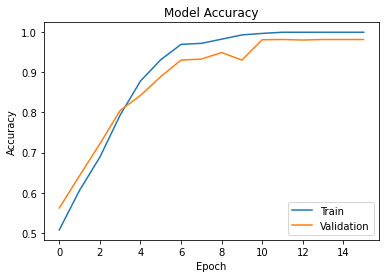

In [22]:
# Doğruluk (Accuracy) Grafiği

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [23]:
#Get a prediction from the neural network
y_pred=cnn.predict(test_data)

In [24]:
#The prediction is a sequence of 4 probabilities. We choose the label with the highest probability.
y_val=[]
for y in y_pred:
    y_val.append(np.argmax(y))

In [25]:
#Convert back to labels 0-3
y_true=[]
for y in test_label:
    y_true.append(np.argmax(y))

In [26]:
#Let's see how the predictions did
print(confusion_matrix(y_true,y_val))

[[822   5   0   0]
 [  9 515   3   0]
 [  3   9 220   0]
 [  0   0   0  14]]


In [27]:
cm = confusion_matrix(y_true,y_val)

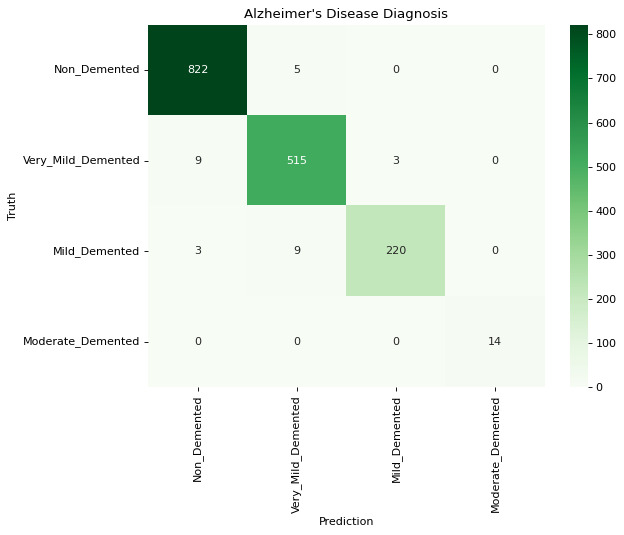

In [28]:
Labels = ["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=Labels, yticklabels=Labels)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [29]:
print("Classification Report")
print(classification_report(y_true,y_val))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       827
           1       0.97      0.98      0.98       527
           2       0.99      0.95      0.97       232
           3       1.00      1.00      1.00        14

    accuracy                           0.98      1600
   macro avg       0.99      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [30]:
print("Accuracy on test data: ",accuracy_score(y_true,y_val))

Accuracy on test data:  0.981875


# Modelin Test Edilmesi

In [31]:
# Tüm tahminleri submission.csv dosyasında karşılaştırıp inceleyelim.
submission = pd.DataFrame(list(zip(y_val, y_true)))
submission.columns =['Predictions', 'Actual']
submission.to_csv("submission.csv", index=False)

In [32]:
# Görüntüleri gösteren fonksiyon.
def show_image(img_path):
  img = mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  return plt.show()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

In [33]:
Labels = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

def predict_label(img_path):
	test_image = Image.open(img_path).convert('L')
	test_image = image.img_to_array(test_image)/255.0
	test_image = test_image.reshape(-1,128,128,1)

	predict_x= cnn.predict(test_image) 
	classes_x=np.argmax(predict_x,axis=1)
	
	return show_image(img_path), Labels[classes_x[0]]

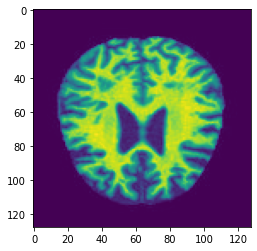

(None, 'Mild_Demented')

In [34]:
predict_label('/content/Dataset/Mild_Demented/mild_101.jpg')

# Modelin Kaydedilmesi

In [35]:
#Saving the model for future use
work_dir = "Dataset/"
model_dir = work_dir + "alzheimer_cnn_model"
cnn.save(model_dir, save_format='h5')
os.listdir(work_dir)

['Non_Demented',
 'alzheimer_cnn_model',
 'Mild_Demented',
 'Very_Mild_Demented',
 'Moderate_Demented']

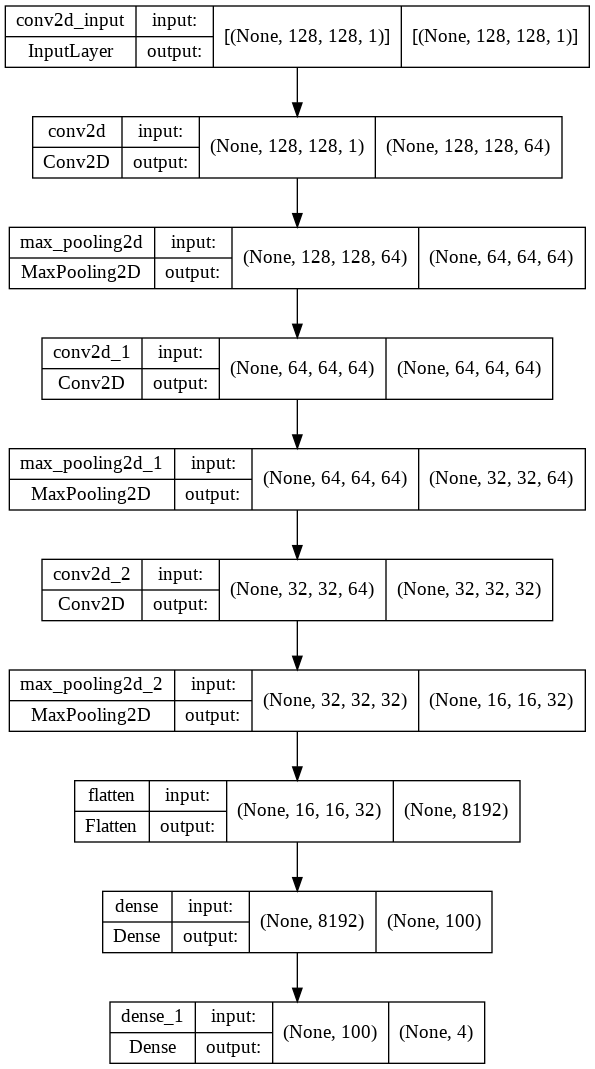

In [36]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)